# Gaussian Laser Beams Lab Notebook

Here, I write down processes for solving various problems in PHYS 4430 Spring 2018 class

## Gaussian Laser Beams

The following libraries will be useful

In [165]:
%matplotlib inline
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import erf,erfc
from scipy.optimize import curve_fit

Helper Function for writing uncertainties

In [166]:
def eformat(num, prec):
    s = "%.*e"%(prec,num)
    mantissa, exp = s.split('e')
    return mantissa, float(exp)

def ansformat(ans,unc,num_sigfig):
    first = eformat(ans,num_sigfig)
    err = unc/10**first[1]
    str_err = eformat(err,0)
    
    return first[0], '{:.2f}'.format(err), 'E{}'.format(int(first[1]))

In this folder, there is a csv file called 'Test_Profile_Data.csv'.  We will use this to perform a nonlinear fitting in Python.  

The first thing to do is to read it into a pandas dataframe.
Once this is complete, we should plot the data as a scatterplot.

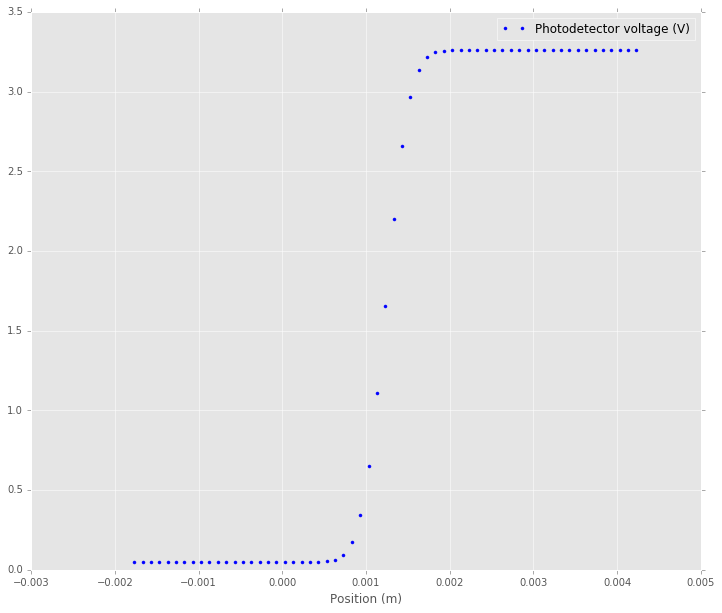

In [167]:
data = pd.DataFrame(pd.read_csv('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/Test_Profile_Data.csv'))
data1 = pd.read_csv('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/Test_Profile_Data.csv', index_col='Position (m)')
plt.style.use('ggplot')
data1.plot(style='b.',xlim=(-.003,.005),figsize=(12,10))
plt.show()

We now create a function with the desired parameters.

In [168]:
def power(x,a,w,c,d):
    return a*erf(np.sqrt(2)/w*(x+c))+d

and then provide an initial guess prior to implementing scipy's curve_fit

In [169]:
init_vals = [3,1,-.001,0]
best_vals, covar = curve_fit(power, data1.index, data1['Photodetector voltage (V)'], p0 = init_vals)
print(best_vals)

[  1.60459986e+00   4.52000000e-04  -1.23000000e-03   1.65459986e+00]


and append it to the dataframe in a seperate column

In [170]:
data1['Best Fit']=power(data1.index,*best_vals)

Finally, we plot both the data and the best fit curve on the same plot with the desired information.

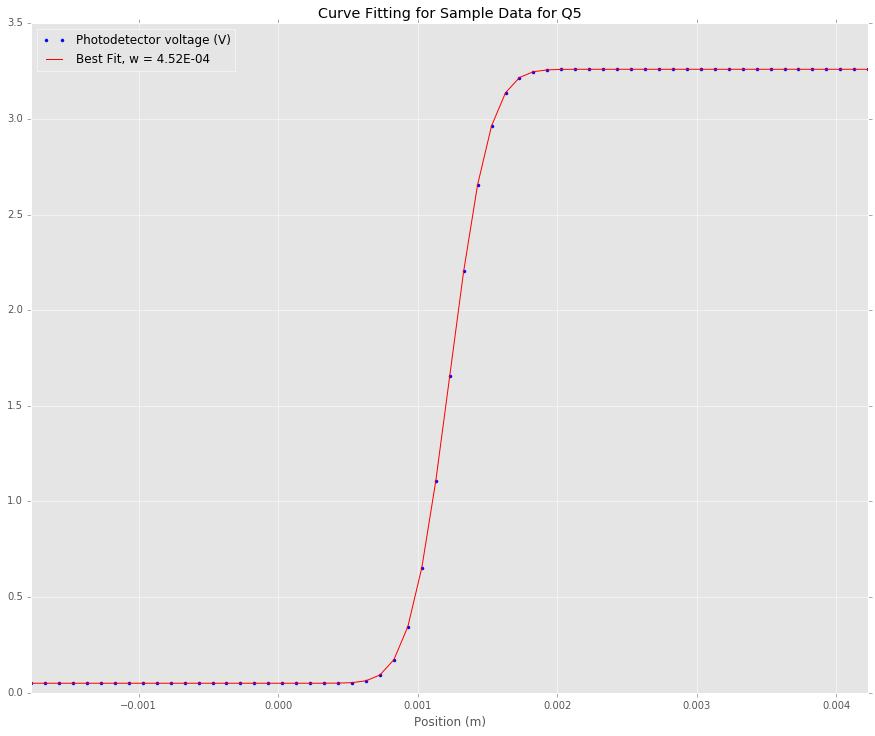

In [171]:
#plt.style.use('ggplot')
data1['Photodetector voltage (V)'].plot(color='b', style='.',legend=True, figsize = (15,12))
data1['Best Fit'].plot(color='r',style='-',label = 'Best Fit, w = {:.2E}'.format(best_vals[1]), legend=True)
plt.title('Curve Fitting for Sample Data for Q5')
plt.legend(loc='best')

plt.show()

### Questions 9-11

We now repeat the process above for the data we collected by hand, and stored in "/home/bjorn/Documents/CU/PHYS_4430/gauss_width.csv"

We need to convert our photodetector voltage into power in detected from laser.
This is accomplished by
$$
\begin{align*}
    P_{in} &= \frac{V_{meas} - V_{offset}}{Spectral Resistivity \cdot Transimpedance Gain}\\
    &= \frac{V_{meas} - V_{offset}}{\left( 0.42 \frac{A}{W} \right) \left(1.51E3 \frac{V}{A}\right)}\\
    &= \frac{V_{meas} - V_{offset}}{634.2 \frac{V}{W}}
\end{align*}
$$

[  2.05264922e+04   4.19102725e-04   7.66863216e-03   1.32301332e-05]
[  1.52793952e+02   1.73184277e-06   6.40717839e-07   4.30381886e-06]


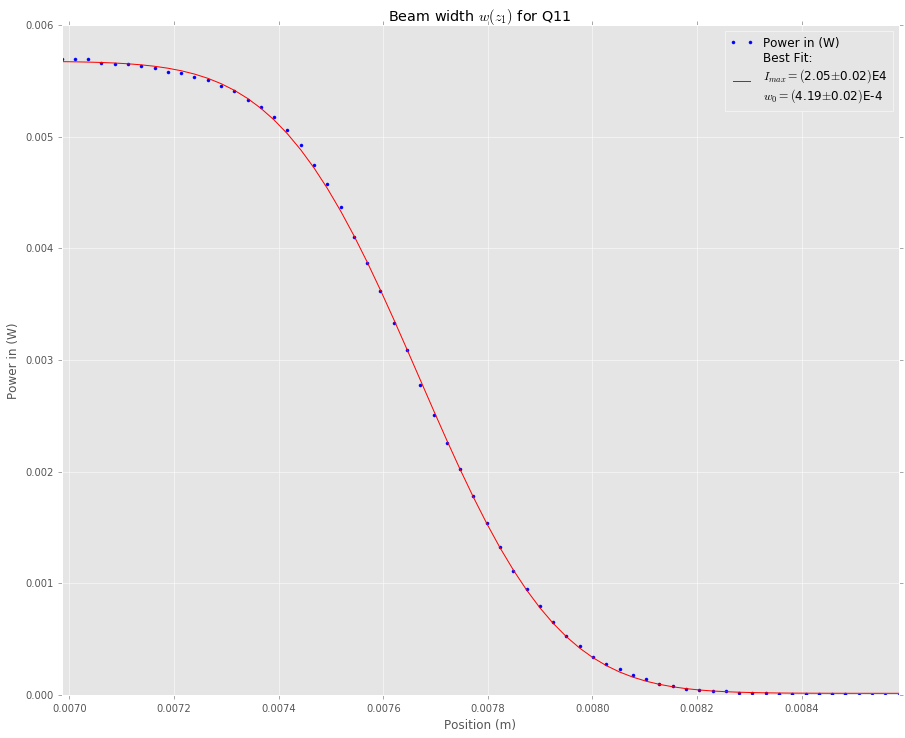

In [172]:
def power_fit(x,I,w,c,d):
    return np.pi*w**2*I/4*erfc(np.sqrt(2)*(x-c)/w)+d

width_data = pd.read_csv('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/gauss_width.csv', index_col = 'Position (m)')
#plt.style.use('ggplot')
#width_data.plot(style='b.',figsize=(12,10))
#plt.show()

fit_guess = [2.05E4,4.19E-4,8E-3,1E-5]
fit_vals, fit_covar = curve_fit(power_fit, width_data.index, width_data['Power in (W)'], p0 = fit_guess)

print(fit_vals)
#print(fit_covar)
print(np.sqrt(np.diag(fit_covar)))

intensity_result = ansformat(fit_vals[0],np.sqrt(np.diag(fit_covar))[0],2)
width_result = ansformat(fit_vals[1],np.sqrt(np.diag(fit_covar))[1],2)

width_data['Best Fit']=power_fit(width_data.index,*fit_vals)

width_data['Power in (W)'].plot(color='b', style='.',legend=True, figsize = (15,12))
width_data['Best Fit'].plot(color='r',style='-',label = 'Best Fit:\n'+\
                              '$I_{max} = ( $' + intensity_result[0] + '$ \pm $'+ intensity_result[1] + '$)$' + intensity_result[2]+ '\n'\
                             '$w_0 = ( $' + width_result[0] + '$ \pm $'+ width_result[1] + '$)$' + width_result[2], legend=True)#'Best Fit w = ${:.2E}\pm{:.0E}m$, I = {:.2E}W'.format(fit_vals[1], np.sqrt(np.diag(fit_covar))[1] , fit_vals[0]), legend=True)
plt.ylabel('Power in (W)')
plt.title('Beam width $w(z_1)$ for Q11')
plt.legend(loc='best')

plt.show()

We are going to have to run this curve fitting repeatedly in the week 2 section of this lab, so lets codify a process that takes files from a library of runs, fits each run, and returns a pandas datafile of [ index : z-position, col 1 : beam width, col2 : beam uncertainty

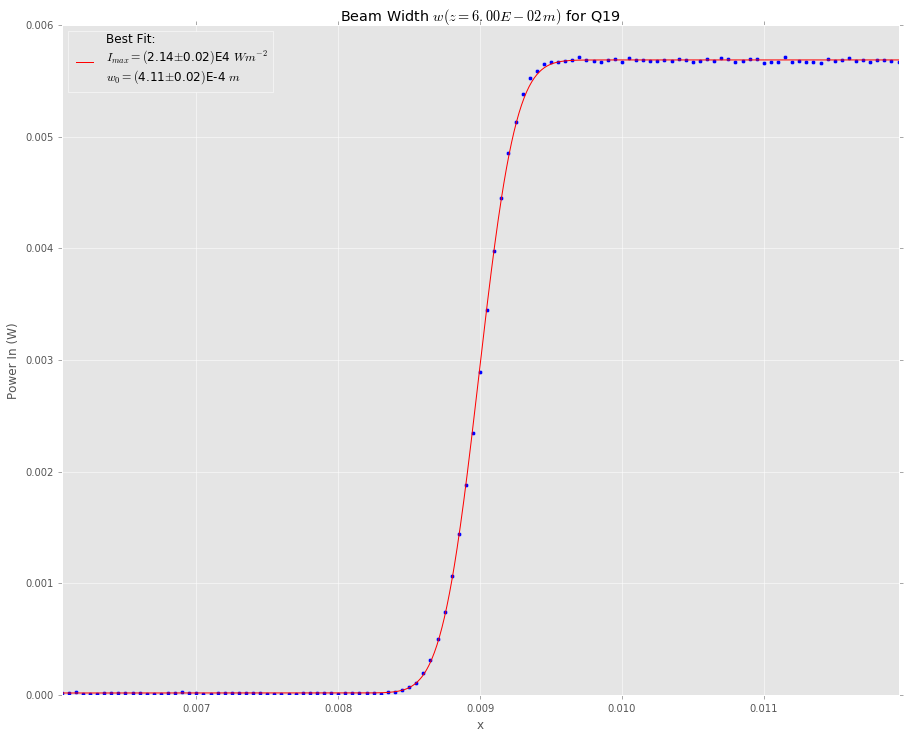

In [173]:
###THIS VERSION IS FOR Z IN INCHES####

class BeamWidthIN:
    """
    Given a 'n inch from aperature.lvm' file from Ben's Labview data, where the first column is position in (mm) 
    and the second is photodetector voltage (V), conditions the data by reading it into a pandas data array, giving
    the headers 'Position (m)' and 'Photodetector voltage (V)' to each column, making the position column the index,
    and multiplying the first column by 10^-3 to convert to meters.
    It then converts the 'n' in the title from inches to meters and stores it as an attribute to be used later.
    
    Generates a best fit curve corresponding to the expected error function fit.
    Has values and errors for beam width, as well as distance of razor from laser
    """
    
    def __init__(self, datafile, offset, I_guess = 2.0E4, w_guess = 4.0E-4, c_guess = .0085, d_guess = 1.0E-5):
        self.filename = datafile
        self.df = pd.read_csv(datafile, sep='\t',names = ["Position (m)", "Photodetector Voltage (V)"])
        self.z_coord = float(self.filename[0])*2.54E-2
        self.guess = [I_guess, w_guess, c_guess, d_guess]
        
        self.offset = offset
        
        #self.df = self.df.set_index('Position (m)')
        self.df['Position (m)'] *= 10**-3
        self.guess[2] = np.median(self.df['Position (m)'])
        
        self.df['Power In (W)'] = (self.df['Photodetector Voltage (V)']-self.offset)/634.2

        self.fit_vals, self.fit_covar = curve_fit(self.erf_fit, self.df['Position (m)'], self.df['Power In (W)'], p0 = self.guess)
        self.width_val = self.fit_vals[1]
        self.width_err = np.sqrt(np.diag(self.fit_covar))[1]
        
        self.intensity_text = ansformat(self.fit_vals[0], np.sqrt(np.diag(self.fit_covar))[0],2)
        self.width_text = ansformat(self.fit_vals[1], np.sqrt(np.diag(self.fit_covar))[1],2)
        
        self.df['Best Fit'] = self.erf_fit(self.df['Position (m)'], *self.fit_vals)
        self
        
        self.best_fit = pd.DataFrame(data = {'x':np.linspace(min(self.df['Position (m)']),max(self.df['Position (m)']),1000)})
        self.best_fit['best'] = self.erf_fit(self.best_fit['x'],*self.fit_vals)
        
        
    def erf_fit(self, x, I, w, c, d):
        return np.pi*w**2*I/4*erf(np.sqrt(2)*(x-c)/w)+d
        
        
    def plot(self):
        
        ax1 = self.df.plot(kind = 'scatter', x = 'Position (m)', y = 'Power In (W)', color = 'b', style = '.', legend = True, figsize = (15,12))
        self.best_fit.plot(x = 'x', y = 'best', ax = ax1, color = 'r', style='-', label= 'Best Fit:\n' + \
                              '$I_{max} = ( $' + self.intensity_text[0] + '$ \pm $'+ self.intensity_text[1] + '$)$' + self.intensity_text[2]+ ' $Wm^{-2}$'+ '\n'\
                             '$w_0 = ( $' + self.width_text[0] + '$ \pm $'+ self.width_text[1] + '$)$' + self.width_text[2] + ' $m$', legend=True)

        plt.title('Beam Width $w(z = {:.2E}\, m)$ for Q19'.format(self.z_coord))
        plt.xlim(self.xmin, self.xmax)
        plt.ylim(self.ymin, self.ymax)
        plt.legend(loc='best')
        
        plt.show()


os.chdir('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/beam width (in)/')
test = BeamWidth('6 inches from aperature.lvm', .001)
#test.analyze()
test.df#['Position (m)']
test.plot()
# print(test.width_val)
# print(test.width_err)

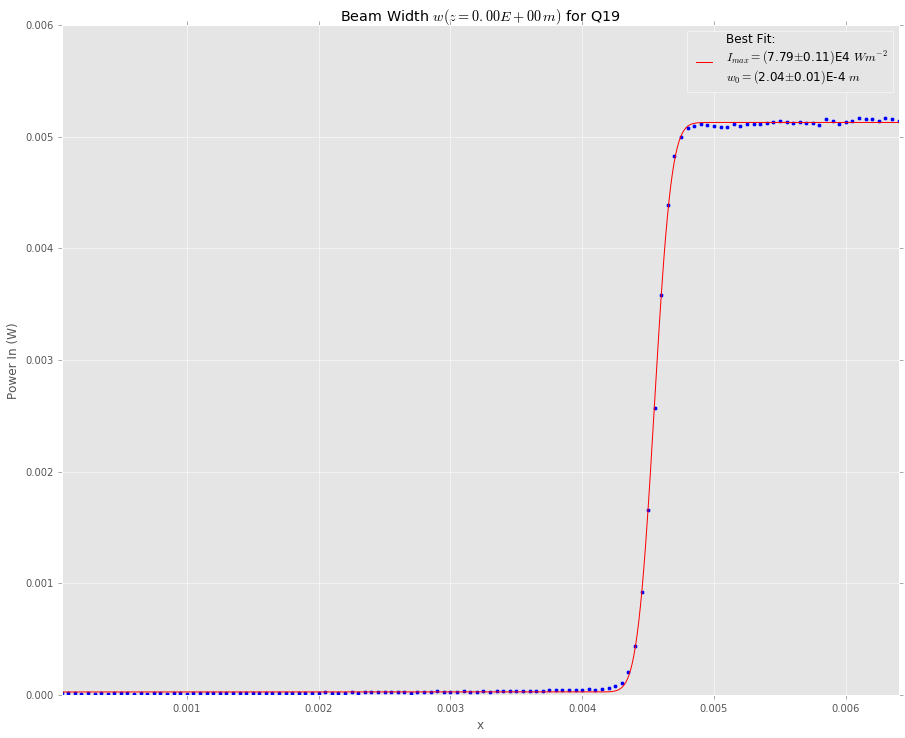

In [174]:
#### THIS VERSION IS FOR Z IN CM ####

class BeamWidthCM_Final:
    """
    Given a 'n inch from aperature.lvm' file from Ben's Labview data, where the first column is position in (mm) 
    and the second is photodetector voltage (V), conditions the data by reading it into a pandas data array, giving
    the headers 'Position (m)' and 'Photodetector voltage (V)' to each column, making the position column the index,
    and multiplying the first column by 10^-3 to convert to meters.
    It then converts the 'n' in the title from inches to meters and stores it as an attribute to be used later.
    
    Generates a best fit curve corresponding to the expected error function fit.
    Has values and errors for beam width, as well as distance of razor from laser
    """
    
    def __init__(self, datafile, offset=.001, I_guess = 2.0E4, w_guess = 4.0E-4, c_guess = .0085, d_guess = 1.0E-5):
        self.filename = datafile
        self.df = pd.read_csv(datafile, sep='\t',names = ["Position (m)", "Photodetector Voltage (V)"])
        self.z_coord = float(self.filename[0])*1.0E-2
        self.guess = [I_guess, w_guess, c_guess, d_guess]
        
        self.offset = offset
        
        #self.df = self.df.set_index('Position (m)')
        self.df['Position (m)'] *= 10**-3
        self.guess[2] = np.median(self.df['Position (m)'])
        
        self.df['Power In (W)'] = (self.df['Photodetector Voltage (V)']-self.offset)/634.2

        self.fit_vals, self.fit_covar = curve_fit(self.erf_fit, self.df['Position (m)'], self.df['Power In (W)'], p0 = self.guess)
        self.width_val = self.fit_vals[1]
        self.width_err = np.sqrt(np.diag(self.fit_covar))[1]
        
        self.intensity_text = ansformat(self.fit_vals[0], np.sqrt(np.diag(self.fit_covar))[0],2)
        self.width_text = ansformat(self.fit_vals[1], np.sqrt(np.diag(self.fit_covar))[1],2)
        
        self.df['Best Fit'] = self.erf_fit(self.df['Position (m)'], *self.fit_vals)
        self
        
        self.best_fit = pd.DataFrame(data = {'x':np.linspace(min(self.df['Position (m)']),max(self.df['Position (m)']),1000)})
        self.best_fit['best'] = self.erf_fit(self.best_fit['x'],*self.fit_vals)
        
        
    def erf_fit(self, x, I, w, c, d):
        return np.pi*w**2*I/4*erf(np.sqrt(2)*(x-c)/w)+d
        
        
    def plot(self):
        
        ax1 = self.df.plot(kind = 'scatter', x = 'Position (m)', y = 'Power In (W)', color = 'b', style = '.', legend = True, figsize = (15,12))
        self.best_fit.plot(x = 'x', y = 'best', ax = ax1, color = 'r', style='-', label= 'Best Fit:\n' + \
                              '$I_{max} = ( $' + self.intensity_text[0] + '$ \pm $'+ self.intensity_text[1] + '$)$' + self.intensity_text[2]+ ' $Wm^{-2}$'+ '\n'\
                             '$w_0 = ( $' + self.width_text[0] + '$ \pm $'+ self.width_text[1] + '$)$' + self.width_text[2] + ' $m$', legend=True)

        plt.title('Beam Width $w(z = {:.2E}\, m)$ for Q19'.format(self.z_coord))
        plt.ylim(0,.006)
        plt.legend(loc='best')
        
        plt.show()


os.chdir('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/100mm lens run 2 (cm)/')
test = BeamWidth('05.0 cm distance from100mm lens.lvm', .001)
#test.analyze()
test.df#['Position (m)']
test.plot()
# print(test.width_val)
# print(test.width_err)

In [175]:
# ### THIS VERSION IS FOR Z IN INCHES ####


# class BeamProfileIN:
#     """
#     Given a directory containing various beam width measurements at given z distances from a source, turns each
#     measurement into a BeamWidth class and plots its width (with error bars) against its z-position.  
#     It then curve fits this data to obtain a measurement of its beam waist and z-location of this waist
#     """
#     def __init__(self, file_directory, xmin, xmax, ymin, ymax):#, w0_guess = 90.0E-6, zw_guess = .34):
#         self.directory = file_directory
#         os.chdir(file_directory)
        
#         self.filenames = glob.glob('*.lvm')
        
#         self.xmin = xmin
#         self.xmax = xmax
#         self.ymin = ymin
#         self.ymax = ymax
        
                
#         #self.list_of_dfs = [pd.read_csv(filename, sep='/t', names = []) for filename in self.filenames]
#         self.profile_dict = {}

#         for file in self.filenames:
#             self.profile_dict[file[:2]] = BeamWidth(file,.001)
            
#         self.profile_df = pd.DataFrame(columns = ['z (m)','Beam Width (m)', 'Beam Error (m)'])
        
#         for key in self.profile_dict:
#             self.profile_df.loc[int(key)] = [float(key)*2.54E-2, self.profile_dict[key].width_val, self.profile_dict[key].width_err]
        
#         #self.profile = self.profile_df.set_index('z (m)')
        
#         self.profile_df = self.profile_df.sort_index()
        
#         self.guess = [min(self.profile_df['Beam Width (m)']), np.median(self.profile_df['z (m)'])]
#         self.fit_vals, self.fit_covar = curve_fit(self.waist_fit, self.profile_df['z (m)'], self.profile_df['Beam Width (m)'], p0 = self.guess)
        
#         self.waist_val = self.fit_vals[0]
#         self.waist_err = np.sqrt(np.diag(self.fit_covar))[0]
        
#         self.zw_val = self.fit_vals[1]
#         self.zw_err = np.sqrt(np.diag(self.fit_covar))[1]
        
#         self.waist_text = ansformat(self.fit_vals[0], np.sqrt(np.diag(self.fit_covar))[0],2)
#         self.zw_text = ansformat(self.fit_vals[1], np.sqrt(np.diag(self.fit_covar))[1],2)
        
#         self.profile_df['Best Fit'] = self.waist_fit(self.profile_df['z (m)'], *self.fit_vals)
        
#         self.best_fit = pd.DataFrame(data = {'z':np.linspace(0,.35,1000)})
#         self.best_fit['best'] = self.waist_fit(self.best_fit['z'],*self.fit_vals)
        
        
#     def waist_fit(self, z, w0,zw):
#         return w0 * np.sqrt(1 + np.power(632.8E-9/(np.pi*w0**2) * (z - zw),2))
    
    
#     def plot(self):
#         ax1 = self.profile_df.plot(kind = 'scatter', x = 'z (m)', y = 'Beam Width (m)', yerr = 'Beam Error (m)', color = 'b', style = '.', legend = True, figsize = (15,12))
#         self.best_fit.plot(x = 'z', y = 'best', ax = ax1, color = 'r', style = '-', label = 'Best Fit:\n' + \
#                                         '$w_0 = ( $' + self.waist_text[0] + '$ \pm $' + self.waist_text[1] + '$)$' + self.waist_text[2] + '$m$' + '\n'\
#                                         '$z_w = ( $' + self.zw_text[0] + '$ \pm $' + self.zw_text[1] + '$)$' + self.zw_text[2] + ' $m$', legend=True)
#         plt.title('Spatial Beam Profile along $z$ for Q19 \n {}'.format(self.directory.split('/')[-1]))
#         plt.xlim(self.xmin, self.xmax)
#         plt.ylim(self.ymin, self.ymax)
#         plt.xlabel('$z\,(m)$')
#         plt.ylabel('$w(z)\, (m)$')
#         plt.legend(loc = 'best')
        
#         plt.show()

In [176]:
# #### THIS VERSION IS FOR Z IN CM ####


# class BeamProfileCM:
#     """
#     Given a directory containing various beam width measurements at given z distances from a source, turns each
#     measurement into a BeamWidth class and plots its width (with error bars) against its z-position.  
#     It then curve fits this data to obtain a measurement of its beam waist and z-location of this waist
#     """
#     def __init__(self, file_directory, xmin, xmax, ymin, ymax):#, w0_guess = 90.0E-6, zw_guess = .34):
#         self.directory = file_directory
#         os.chdir(file_directory)
        
#         self.filenames = glob.glob('*.lvm')
        
#         self.xmin = xmin
#         self.xmax = xmax
#         self.ymin = ymin
#         self.ymax = ymax     
        
                
#         #self.list_of_dfs = [pd.read_csv(filename, sep='/t', names = []) for filename in self.filenames]
#         self.profile_dict = {}

#         for file in self.filenames:
#             self.profile_dict[file[:2]] = BeamWidth(file,.001)
            
#         self.profile_df = pd.DataFrame(columns = ['z (m)','Beam Width (m)', 'Beam Error (m)'])
        
#         for key in self.profile_dict:
#             self.profile_df.loc[int(key)] = [float(key)*1.0E-2, self.profile_dict[key].width_val, self.profile_dict[key].width_err]
        
#         #self.profile = self.profile_df.set_index('z (m)')
        
#         self.profile_df = self.profile_df.sort_index()
        
#         self.guess = [min(self.profile_df['Beam Width (m)']), np.median(self.profile_df['z (m)'])]
#         self.fit_vals, self.fit_covar = curve_fit(self.waist_fit, self.profile_df['z (m)'], self.profile_df['Beam Width (m)'], p0 = self.guess)
        
#         self.waist_val = self.fit_vals[0]
#         self.waist_err = np.sqrt(np.diag(self.fit_covar))[0]
        
#         self.zw_val = self.fit_vals[1]
#         self.zw_err = np.sqrt(np.diag(self.fit_covar))[1]
        
#         self.waist_text = ansformat(self.fit_vals[0], np.sqrt(np.diag(self.fit_covar))[0],2)
#         self.zw_text = ansformat(self.fit_vals[1], np.sqrt(np.diag(self.fit_covar))[1],2)
        
#         self.profile_df['Best Fit'] = self.waist_fit(self.profile_df['z (m)'], *self.fit_vals)
        
#         self.best_fit = pd.DataFrame(data = {'z':np.linspace(0,.35,1000)})
#         self.best_fit['best'] = self.waist_fit(self.best_fit['z'],*self.fit_vals)
        
        
#     def waist_fit(self, z, w0,zw):
#         return w0 * np.sqrt(1 + np.power(632.8E-9/(np.pi*w0**2) * (z - zw),2))
    
    
#     def plot(self):
#         ax1 = self.profile_df.plot(kind = 'scatter', x = 'z (m)', y = 'Beam Width (m)', yerr = 'Beam Error (m)', color = 'b', style = '.', legend = True, figsize = (15,12))
#         self.best_fit.plot(x = 'z', y = 'best', ax = ax1, color = 'r', style = '-', label = 'Best Fit:\n' + \
#                                         '$w_0 = ( $' + self.waist_text[0] + '$ \pm $' + self.waist_text[1] + '$)$' + self.waist_text[2] + '$m$' + '\n'\
#                                         '$z_w = ( $' + self.zw_text[0] + '$ \pm $' + self.zw_text[1] + '$)$' + self.zw_text[2] + ' $m$', legend=True)
#         plt.title('Spatial Beam Profile along $z$ for Q19 \n {}'.format(self.directory.split('/')[-1]))
#         plt.xlim(self.xmin, self.xmax)
#         plt.ylim(self.ymin, self.ymax)
#         plt.xlabel('$z\,(m)$')
#         plt.ylabel('$w(z)\, (m)$')
#         plt.legend(loc = 'best')
        
#         plt.show()

In [177]:
### THIS VERSION IS FOR Z IN INCHES ####

class BeamProfileIN:
    """
    Given a directory containing various beam width measurements at given z distances from a source, turns each
    measurement into a BeamWidth class and plots its width (with error bars) against its z-position.  
    It then curve fits this data to obtain a measurement of its beam waist and z-location of this waist
    """
    def __init__(self, file_directory, xmin, xmax, ymin, ymax):#, w0_guess = 90.0E-6, zw_guess = .34):
        self.directory = file_directory
        os.chdir(file_directory)
        
        self.filenames = glob.glob('*.lvm')
        
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
                
        #self.list_of_dfs = [pd.read_csv(filename, sep='/t', names = []) for filename in self.filenames]
        self.profile_list = []

        for file in self.filenames:
            self.profile_list.append([float(file[:2])*2.54E-2, BeamWidth(file,.001).width_val, BeamWidth(file,.001).width_err])
            
        self.profile_df = pd.DataFrame(columns = ['z (m)','Beam Width (m)', 'Beam Error (m)'])
        
        for i in range(len(self.profile_list)):
            self.profile_df.loc[i]=self.profile_list[i]
        
        #self.profile = self.profile_df.set_index('z (m)')
        
        #self.profile_df = self.profile_df.sort_index()
        
        self.guess = [min(self.profile_df['Beam Width (m)']), np.median(self.profile_df['z (m)'])]
        self.fit_vals, self.fit_covar = curve_fit(self.waist_fit, self.profile_df['z (m)'], self.profile_df['Beam Width (m)'], p0 = self.guess)
        
        self.waist_val = self.fit_vals[0]
        self.waist_err = np.sqrt(np.diag(self.fit_covar))[0]
        
        self.zw_val = self.fit_vals[1]
        self.zw_err = np.sqrt(np.diag(self.fit_covar))[1]
        
        self.waist_text = ansformat(self.fit_vals[0], np.sqrt(np.diag(self.fit_covar))[0],2)
        self.zw_text = ansformat(self.fit_vals[1], np.sqrt(np.diag(self.fit_covar))[1],2)
        
        self.profile_df['Best Fit'] = self.waist_fit(self.profile_df['z (m)'], *self.fit_vals)
        
        self.best_fit = pd.DataFrame(data = {'z':np.linspace(0,.4,1000)})
        self.best_fit['best'] = self.waist_fit(self.best_fit['z'],*self.fit_vals)
        
        
    def waist_fit(self, z, w0,zw):
        return w0 * np.sqrt(1 + np.power(632.8E-9/(np.pi*w0**2) * (z - zw),2))
    
    
    def plot(self):
        ax1 = self.profile_df.plot(kind = 'scatter', x = 'z (m)', y = 'Beam Width (m)', yerr = 'Beam Error (m)', color = 'b', style = '.', legend = True, figsize = (15,12))
        self.best_fit.plot(x = 'z', y = 'best', ax = ax1, color = 'r', style = '-', label = 'Best Fit:\n' + \
                                        '$w_0 = ( $' + self.waist_text[0] + '$ \pm $' + self.waist_text[1] + '$)$' + self.waist_text[2] + '$m$' + '\n'\
                                        '$z_w = ( $' + self.zw_text[0] + '$ \pm $' + self.zw_text[1] + '$)$' + self.zw_text[2] + ' $m$', legend=True)
        plt.title('Spatial Beam Profile along $z$ for Q19 \n {}'.format(self.directory.split('/')[-1]))
        plt.xlim(self.xmin, self.xmax)
        plt.ylim(self.ymin, self.ymax)
        plt.xlabel('$z\,(m)$')
        plt.ylabel('$w(z)\, (m)$')
        plt.legend(loc = 'best')
        
        plt.show()

In [178]:
#### THIS VERSION IS FOR Z IN CM ####


class BeamProfileCM:
    """
    Given a directory containing various beam width measurements at given z distances from a source, turns each
    measurement into a BeamWidth class and plots its width (with error bars) against its z-position.  
    It then curve fits this data to obtain a measurement of its beam waist and z-location of this waist
    """
    def __init__(self, file_directory, xmin, xmax, ymin, ymax):#, w0_guess = 90.0E-6, zw_guess = .34):
        self.directory = file_directory
        os.chdir(file_directory)
        
        self.filenames = glob.glob('*.lvm')
        
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax     
        
                
        #self.list_of_dfs = [pd.read_csv(filename, sep='/t', names = []) for filename in self.filenames]
        self.profile_list = []

        for file in self.filenames:
            self.profile_list.append([file[:2], BeamWidth(file,.001).width_val, BeamWidth(file,.001).width_err])
            
        self.profile_df = pd.DataFrame(columns = ['z (m)','Beam Width (m)', 'Beam Error (m)'])
        
        for i in range(len(self.profile_list)):
            self.profile_df.loc[i]=self.profile_list[i]
        
        #self.profile = self.profile_df.set_index('z (m)')
        
        #self.profile_df = self.profile_df.sort_index()
        
        self.guess = [min(self.profile_df['Beam Width (m)']), np.median(self.profile_df['z (m)'])]
        self.fit_vals, self.fit_covar = curve_fit(self.waist_fit, self.profile_df['z (m)'], self.profile_df['Beam Width (m)'], p0 = self.guess)
        
        self.waist_val = self.fit_vals[0]
        self.waist_err = np.sqrt(np.diag(self.fit_covar))[0]
        
        self.zw_val = self.fit_vals[1]
        self.zw_err = np.sqrt(np.diag(self.fit_covar))[1]
        
        self.waist_text = ansformat(self.fit_vals[0], np.sqrt(np.diag(self.fit_covar))[0],2)
        self.zw_text = ansformat(self.fit_vals[1], np.sqrt(np.diag(self.fit_covar))[1],2)
        
        self.profile_df['Best Fit'] = self.waist_fit(self.profile_df['z (m)'], *self.fit_vals)
        
        self.best_fit = pd.DataFrame(data = {'z':np.linspace(0,.4,1000)})
        self.best_fit['best'] = self.waist_fit(self.best_fit['z'],*self.fit_vals)
        
        
    def waist_fit(self, z, w0,zw):
        return w0 * np.sqrt(1 + np.power(632.8E-9/(np.pi*w0**2) * (z - zw),2))
    
    
    def plot(self):
        ax1 = self.profile_df.plot(kind = 'scatter', x = 'z (m)', y = 'Beam Width (m)', yerr = 'Beam Error (m)', color = 'b', style = '.', legend = True, figsize = (15,12))
        self.best_fit.plot(x = 'z', y = 'best', ax = ax1, color = 'r', style = '-', label = 'Best Fit:\n' + \
                                        '$w_0 = ( $' + self.waist_text[0] + '$ \pm $' + self.waist_text[1] + '$)$' + self.waist_text[2] + '$m$' + '\n'\
                                        '$z_w = ( $' + self.zw_text[0] + '$ \pm $' + self.zw_text[1] + '$)$' + self.zw_text[2] + ' $m$', legend=True)
        plt.title('Spatial Beam Profile along $z$ for Q19 \n {}'.format(self.directory.split('/')[-1]))
        plt.xlim(self.xmin, self.xmax)
        plt.ylim(self.ymin, self.ymax)
        plt.xlabel('$z\,(m)$')
        plt.ylabel('$w(z)\, (m)$')
        plt.legend(loc = 'best')
        
        plt.show()

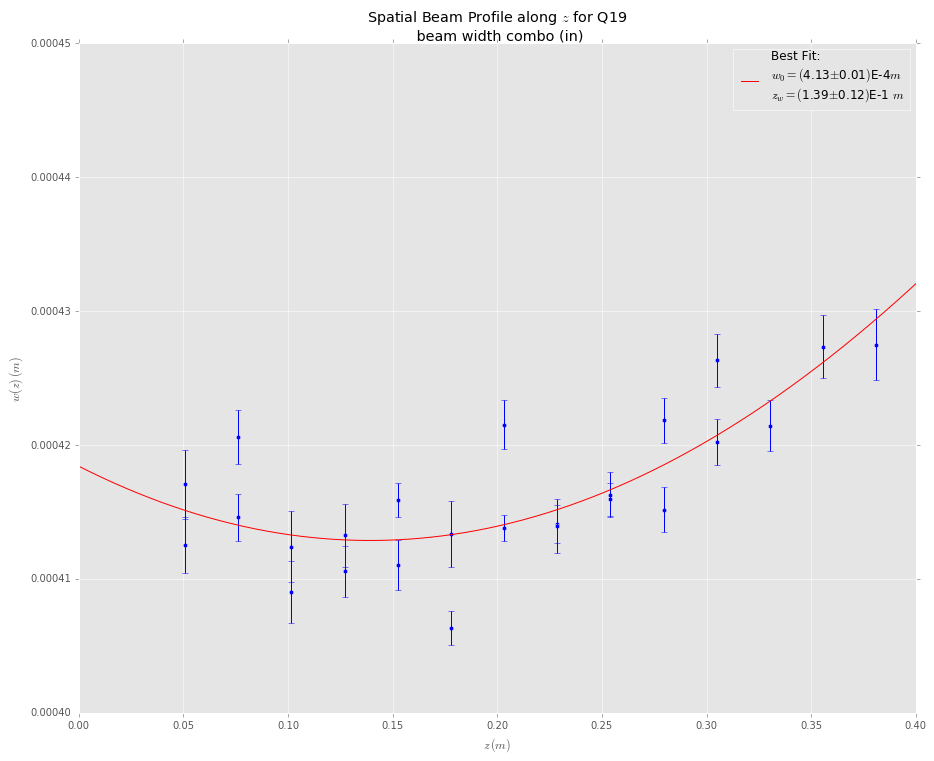

In [179]:
test1 = BeamProfileIN('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/beam width combo (in)', 0,.4,0.0004,.00045)
#test1.profile_df
test1.plot()

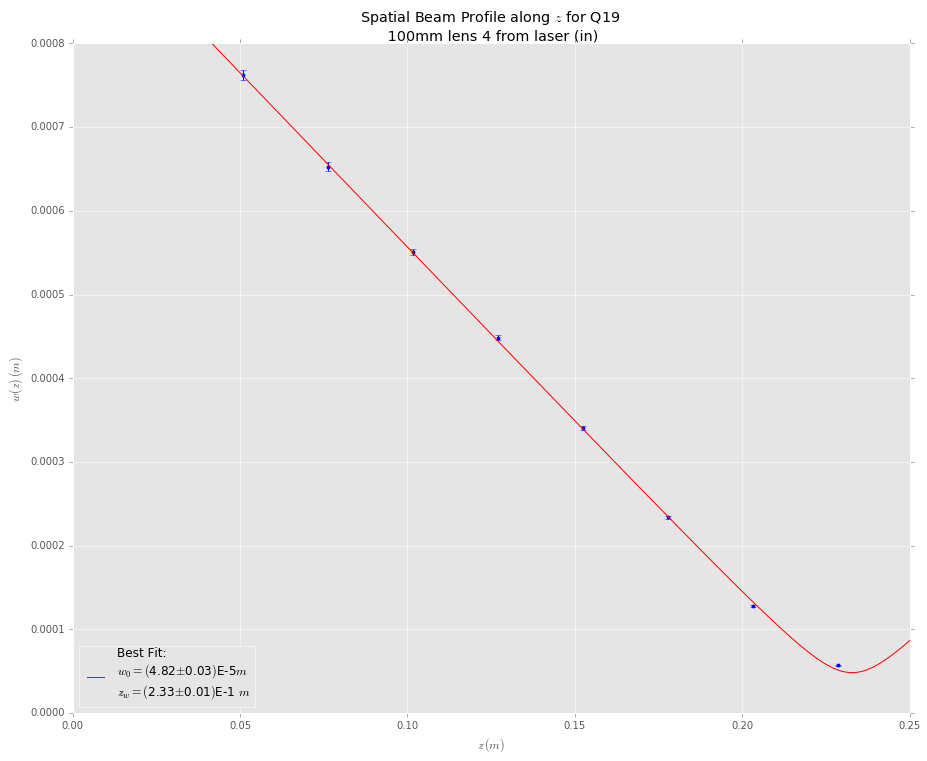

In [180]:
test3 = BeamProfileIN('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/100mm lens 4 from laser (in)',0,0.25,.000,.0008)
test3.plot()

In [181]:
test4 = BeamProfile('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/150mm lens 2 from laser')
test4.plot()

TypeError: __init__() missing 4 required positional arguments: 'xmin', 'xmax', 'ymin', and 'ymax'

In [ ]:
test5 = BeamProfile('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/150mm lens run 2 (cm)')
test5.plot()

In [183]:
test6 = BeamProfile('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/100mm lens run 2 (cm)')
test6.plot()#### THIS VERSION IS FOR Z IN CM ####



TypeError: __init__() missing 4 required positional arguments: 'xmin', 'xmax', 'ymin', and 'ymax'

In [185]:
class BeamWidthCM_Final:
    """
    Given a 'n inch from aperature.lvm' file from Ben's Labview data, where the first column is position in (mm) 
    and the second is photodetector voltage (V), conditions the data by reading it into a pandas data array, giving
    the headers 'Position (m)' and 'Photodetector voltage (V)' to each column, making the position column the index,
    and multiplying the first column by 10^-3 to convert to meters.
    It then converts the 'n' in the title from inches to meters and stores it as an attribute to be used later.
    
    Generates a best fit curve corresponding to the expected error function fit.
    Has values and errors for beam width, as well as distance of razor from laser
    """
    
    def __init__(self, datafile, offset=.001, I_guess = 2.0E4, w_guess = 4.0E-4, c_guess = .0085, d_guess = 1.0E-5):
        self.filename = datafile
        self.df = pd.read_csv(datafile, sep='\t',names = ["Position (m)", "Photodetector Voltage (V)"])
        self.z_coord = float(self.filename[:5])*1.0E-2
        self.guess = [I_guess, w_guess, c_guess, d_guess]
        
        self.offset = offset
        
        #self.df = self.df.set_index('Position (m)')
        self.df['Position (m)'] *= 10**-3
        self.guess[2] = np.median(self.df['Position (m)'])
        
        self.df['Power In (W)'] = (self.df['Photodetector Voltage (V)']-self.offset)/634.2

        self.fit_vals, self.fit_covar = curve_fit(self.erf_fit, self.df['Position (m)'], self.df['Power In (W)'], p0 = self.guess)
        self.width_val = self.fit_vals[1]
        self.width_err = np.sqrt(np.diag(self.fit_covar))[1]
        
        self.intensity_text = ansformat(self.fit_vals[0], np.sqrt(np.diag(self.fit_covar))[0],2)
        self.width_text = ansformat(self.fit_vals[1], np.sqrt(np.diag(self.fit_covar))[1],2)
        
        self.df['Best Fit'] = self.erf_fit(self.df['Position (m)'], *self.fit_vals)
        self
        
        self.best_fit = pd.DataFrame(data = {'x':np.linspace(min(self.df['Position (m)']),max(self.df['Position (m)']),1000)})
        self.best_fit['best'] = self.erf_fit(self.best_fit['x'],*self.fit_vals)
        
        
    def erf_fit(self, x, I, w, c, d):
        return np.pi*w**2*I/4*erf(np.sqrt(2)*(x-c)/w)+d
        
        
    def plot(self):
        
        ax1 = self.df.plot(kind = 'scatter', x = 'Position (m)', y = 'Power In (W)', color = 'b', style = '.', legend = True, figsize = (15,12))
        self.best_fit.plot(x = 'x', y = 'best', ax = ax1, color = 'r', style='-', label= 'Best Fit:\n' + \
                              '$I_{max} = ( $' + self.intensity_text[0] + '$ \pm $'+ self.intensity_text[1] + '$)$' + self.intensity_text[2]+ ' $Wm^{-2}$'+ '\n'\
                             '$w_0 = ( $' + self.width_text[0] + '$ \pm $'+ self.width_text[1] + '$)$' + self.width_text[2] + ' $m$', legend=True)

        plt.title('Beam Width $w(z = {:.2E}\, m)$ for Q19'.format(self.z_coord))
        plt.ylim(0,.006)
        plt.legend(loc='best')
        
        plt.show()


# os.chdir('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/100mm lens run 2 (cm)/')
# test = BeamWidth('05.0 cm distance from100mm lens.lvm', .001)
# #test.analyze()
# test.df#['Position (m)']
# test.plot()
# # print(test.width_val)
# # print(test.width_err)

In [202]:
#### THIS VERSION IS FOR Z IN CM ####


class BeamProfileCM_Final:
    """
    Given a directory containing various beam width measurements at given z distances from a source, turns each
    measurement into a BeamWidth class and plots its width (with error bars) against its z-position.  
    It then curve fits this data to obtain a measurement of its beam waist and z-location of this waist
    """
    def __init__(self, file_directory, xmin, xmax, ymin, ymax):#, w0_guess = 90.0E-6, zw_guess = .34):
        self.directory = file_directory
        os.chdir(file_directory)
        
        self.filenames = glob.glob('*.lvm')
        
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax     
        
                
        #self.list_of_dfs = [pd.read_csv(filename, sep='/t', names = []) for filename in self.filenames]
        self.profile_list = []

        for file in self.filenames:
            self.profile_list.append([float(file[:5])*10**-2, BeamWidthCM_Final(file,.001).width_val, BeamWidthCM_Final(file,.001).width_err])
            
        self.profile_df = pd.DataFrame(columns = ['z (m)','Beam Width (m)', 'Beam Error (m)'])
        
        for i in range(len(self.profile_list)):
            self.profile_df.loc[i]=self.profile_list[i]
        
        #self.profile = self.profile_df.set_index('z (m)')
        
        #self.profile_df = self.profile_df.sort_index()
        
        self.guess = [min(self.profile_df['Beam Width (m)']), np.median(self.profile_df['z (m)'])]
        self.fit_vals, self.fit_covar = curve_fit(self.waist_fit, self.profile_df['z (m)'], self.profile_df['Beam Width (m)'], p0 = self.guess)
        
        self.waist_val = self.fit_vals[0]
        self.waist_err = np.sqrt(np.diag(self.fit_covar))[0]
        
        self.zw_val = self.fit_vals[1]
        self.zw_err = np.sqrt(np.diag(self.fit_covar))[1]
        
        self.waist_text = ansformat(self.fit_vals[0], np.sqrt(np.diag(self.fit_covar))[0],2)
        self.zw_text = ansformat(self.fit_vals[1], np.sqrt(np.diag(self.fit_covar))[1],2)
        
        self.profile_df['Best Fit'] = self.waist_fit(self.profile_df['z (m)'], *self.fit_vals)
        
        self.best_fit = pd.DataFrame(data = {'z':np.linspace(-.35,0,1000)})
        self.best_fit['best'] = self.waist_fit(self.best_fit['z'],*self.fit_vals)
        
        
    def waist_fit(self, z, w0,zw):
        return w0 * np.sqrt(1 + np.power(632.8E-9/(np.pi*w0**2) * (z - zw),2))
    
    
    def plot(self):
        ax1 = self.profile_df.plot(kind = 'scatter', x = 'z (m)', y = 'Beam Width (m)', yerr = 'Beam Error (m)', color = 'b', style = '.', legend = True, figsize = (15,12))
        self.best_fit.plot(x = 'z', y = 'best', ax = ax1, color = 'r', style = '-', label = 'Best Fit:\n' + \
                                        '$w_0 = ( $' + self.waist_text[0] + '$ \pm $' + self.waist_text[1] + '$)$' + self.waist_text[2] + '$m$' + '\n'\
                                        '$z_w = ( $' + self.zw_text[0] + '$ \pm $' + self.zw_text[1] + '$)$' + self.zw_text[2] + ' $m$', legend=True)
        plt.title('Spatial Beam Profile along $z$ for Q21 \n {}'.format(self.directory.split('/')[-1]))
        plt.xlim(self.xmin, self.xmax)
        plt.ylim(self.ymin, self.ymax)
        plt.xlabel('$z\,(m)$')
        plt.ylabel('$w(z)\, (m)$')
        plt.legend(loc = 'best')
        
        plt.show()

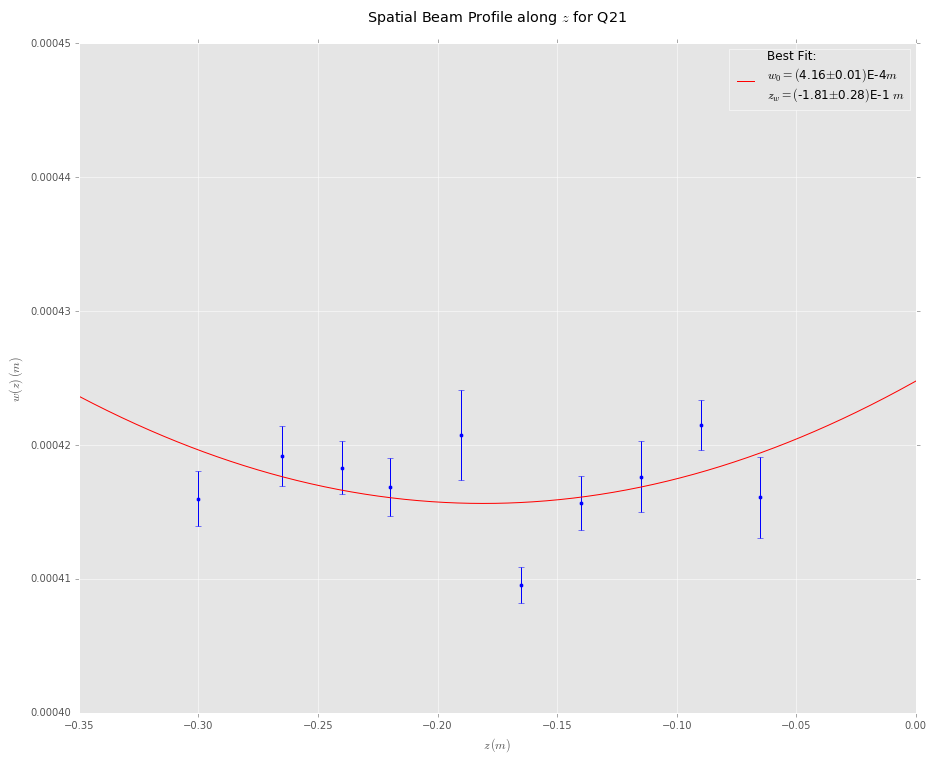

,z (m),Beam Width (m),Beam Error (m),Best Fit
0,-0.090,0.000422,0.000002,0.000418
1,-0.115,0.000418,0.000003,0.000417
2,-0.300,0.000416,0.000002,0.000420
3,-0.220,0.000417,0.000002,0.000416
4,-0.065,0.000416,0.000003,0.000419
5,-0.265,0.000419,0.000002,0.000418
6,-0.240,0.000418,0.000002,0.000417
7,-0.190,0.000421,0.000003,0.000416
8,-0.165,0.000410,0.000001,0.000416
9,-0.140,0.000416,0.000002,0.000416


In [204]:
prelens = BeamProfileCM_Final('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/Q21 150mm lens 30.5 cm from laser/before lens/',-.35,0.,.0004,.00045)
prelens.plot()
prelens.profile_df

In [195]:
#### THIS VERSION IS FOR Z IN CM ####


class BeamProfileCM_Final:
    """
    Given a directory containing various beam width measurements at given z distances from a source, turns each
    measurement into a BeamWidth class and plots its width (with error bars) against its z-position.  
    It then curve fits this data to obtain a measurement of its beam waist and z-location of this waist
    """
    def __init__(self, file_directory, xmin, xmax, ymin, ymax):#, w0_guess = 90.0E-6, zw_guess = .34):
        self.directory = file_directory
        os.chdir(file_directory)
        
        self.filenames = glob.glob('*.lvm')
        
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax     
        
                
        #self.list_of_dfs = [pd.read_csv(filename, sep='/t', names = []) for filename in self.filenames]
        self.profile_list = []

        for file in self.filenames:
            self.profile_list.append([float(file[:5])*10**-2, BeamWidthCM_Final(file,.001).width_val, BeamWidthCM_Final(file,.001).width_err])
            
        self.profile_df = pd.DataFrame(columns = ['z (m)','Beam Width (m)', 'Beam Error (m)'])
        
        for i in range(len(self.profile_list)):
            self.profile_df.loc[i]=self.profile_list[i]
        
        #self.profile = self.profile_df.set_index('z (m)')
        
        #self.profile_df = self.profile_df.sort_index()
        
        self.guess = [min(self.profile_df['Beam Width (m)']), np.median(self.profile_df['z (m)'])]
        self.fit_vals, self.fit_covar = curve_fit(self.waist_fit, self.profile_df['z (m)'], self.profile_df['Beam Width (m)'], p0 = self.guess)
        
        self.waist_val = self.fit_vals[0]
        self.waist_err = np.sqrt(np.diag(self.fit_covar))[0]
        
        self.zw_val = self.fit_vals[1]
        self.zw_err = np.sqrt(np.diag(self.fit_covar))[1]
        
        self.waist_text = ansformat(self.fit_vals[0], np.sqrt(np.diag(self.fit_covar))[0],2)
        self.zw_text = ansformat(self.fit_vals[1], np.sqrt(np.diag(self.fit_covar))[1],2)
        
        self.profile_df['Best Fit'] = self.waist_fit(self.profile_df['z (m)'], *self.fit_vals)
        
        self.best_fit = pd.DataFrame(data = {'z':np.linspace(0,.38,1000)})
        self.best_fit['best'] = self.waist_fit(self.best_fit['z'],*self.fit_vals)
        
        
    def waist_fit(self, z, w0,zw):
        return w0 * np.sqrt(1 + np.power(632.8E-9/(np.pi*w0**2) * (z - zw),2))
    
    
    def plot(self):
        ax1 = self.profile_df.plot(kind = 'scatter', x = 'z (m)', y = 'Beam Width (m)', yerr = 'Beam Error (m)', color = 'b', style = '.', legend = True, figsize = (15,12))
        self.best_fit.plot(x = 'z', y = 'best', ax = ax1, color = 'r', style = '-', label = 'Best Fit:\n' + \
                                        '$w_0 = ( $' + self.waist_text[0] + '$ \pm $' + self.waist_text[1] + '$)$' + self.waist_text[2] + '$m$' + '\n'\
                                        '$z_w = ( $' + self.zw_text[0] + '$ \pm $' + self.zw_text[1] + '$)$' + self.zw_text[2] + ' $m$', legend=True)
        plt.title('Spatial Beam Profile along $z$ for Q21 \n {}'.format(self.directory.split('/')[-1]))
        plt.xlim(self.xmin, self.xmax)
        plt.ylim(self.ymin, self.ymax)
        plt.xlabel('$z\,(m)$')
        plt.ylabel('$w(z)\, (m)$')
        plt.legend(loc = 'best')
        
        plt.show()

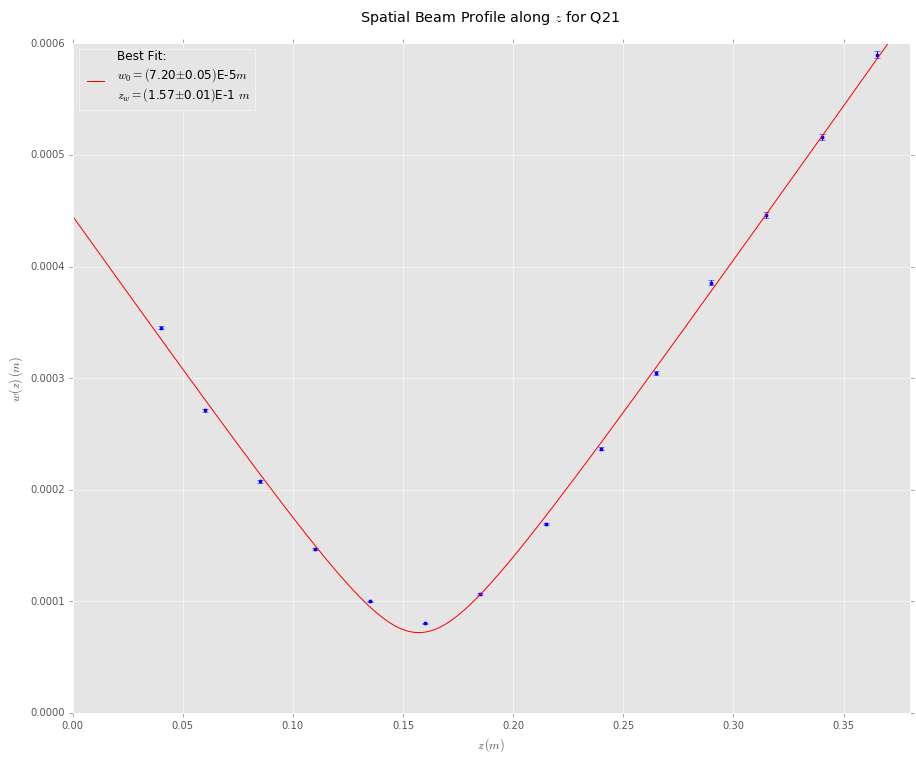

,z (m),Beam Width (m),Beam Error (m),Best Fit
0,0.340,0.000516,2.880854e-06,0.000516
1,0.185,0.000106,7.123106e-07,0.000106
2,0.135,0.000100,6.778646e-07,0.000095
3,0.040,0.000345,1.533137e-06,0.000335
4,0.290,0.000385,2.210900e-06,0.000378
5,0.315,0.000446,2.724899e-06,0.000447
6,0.060,0.000271,1.341246e-06,0.000281
7,0.110,0.000147,1.042601e-06,0.000150
8,0.215,0.000170,8.356139e-07,0.000177
9,0.240,0.000237,1.302874e-06,0.000243


In [197]:
prelens = BeamProfileCM_Final('/home/bjorn/Documents/CU/PHYS_4430/Gaussian_Beam_Lab/Q21 150mm lens 30.5 cm from laser/after lens/',0,.38,.000,.0006)
prelens.plot()
prelens.profile_df

9b) We can tell if the experiment is working by traversing the translation stage across its range and watching the output voltage on the oscilloscope.  We are probably in good shape if we are reading a maximum voltage (around 3 V) when the razor is not blocking any light, but only reading the offset when the razor is completely blocking the light.

9c)  We are going to use the oscilloscope, since we can explore how the measured voltage is changing at different time- and voltage- scales.  This will lead us to a greater confidence in our measurements.

9d) See plots

10a) 

12a)  Yes, if a beam starts out as gaussian, then it will remain so, provided it does not encounter any fields or matter that could change it.

12b)  A lens acts as a fourier transform for a source wave.  If the incoming wave is gaussian, the fourier transform of that wave will also be gaussian, and so the beam will remain a gaussian, but with different characteristics.

12c)  A gaussian beam reflecting will retain its gaussian properties, though the EM wave may have a phase shift

12d)  The beam will reach a minimum spot size at the focus of the lens.  However, it will not be a point.  If it were, the area of the beam would be zero, and the intensity of the field would have to be infinite, which means the field would be infinite.  Furthermore, having a laser

13)
$I(x,y) \propto \rvert E \rvert ^2 =E^*E$

$$
\begin{align*}
    I(x,y) &\propto \rvert E \rvert ^2 =E^*E\\
    &= \rvert E_0 \rvert^2 \frac{w_0}{w(z)} \exp \left(-2\frac{x^2+y^2}{\left(w(z)\right)^2}\right)
\end{align*}
$$
Since all the complex exponentials disappear when multiplied by there conjugates.

So if we take a measurement of $I$ at a specific point along the propogation axis and call its width $w$, we can set $I_{max}= w_0$ and obtain the simple equation

$$
I(x,y) = I_{max} \exp \left(-2\frac{x^2+y^2}{w^2}\right)
$$

14.

a) For equations 8-11, we simply need to substitute $z \mapsto z-z_w$

b) This is easily seen in the substitution rule, which becomes $z \mapsto z$ when $z_w=0$

In [ ]:
def trial_waist(z,w0,zw):
    return w0 * np.sqrt(1 + np.power(632.8E-9/(np.pi*w0**2) * (z - zw),2))

#width_data = pd.read_csv('/home/bjorn/Documents/CU/PHYS_4430/gauss_width.csv', index_col = 'Position (m)')
t_waist_data = pd.read_csv('/home/bjorn/Documents/CU/PHYS_4430/Test_beam_width_data.csv')

fit_guess = [90.0E-6, .34]
t_width_vals, t_width_covar = curve_fit(trial_waist, t_waist_data['Position (m)'], t_waist_data['Beam width w(z) (m)'], p0 = fit_guess)

#print(t_width_vals)
#print(np.sqrt(np.diag(t_width_covar)))

t_waist_data['Best Fit']=trial_waist(t_waist_data['Position (m)'],*t_width_vals)

#print(t_width_vals)

t_waist_result = ansformat(t_width_vals[0],np.sqrt(np.diag(t_width_covar))[0],2)
t_zwaist_result = ansformat(t_width_vals[1],np.sqrt(np.diag(t_width_covar))[1],2)

t_waist_data['Beam width w(z) (m)'].plot(color='b', style='.',legend=True, figsize = (15,12))
t_waist_data['Best Fit'].plot(color='r',style='-', label = 'Best Fit:\n'+\
                              '$w_0 = ( $' + t_waist_result[0] + '$ \pm $'+ t_waist_result[1] + '$)$' + t_waist_result[2]+ '\n'\
                             '$z_w = ( $' + t_zwaist_result[0] + '$ \pm $'+ t_zwaist_result[1] + '$)$' + t_zwaist_result[2], legend=True)
plt.xlabel('z (m)')
plt.ylabel('w(z)')
plt.title('Beam Waist $w_0$ Curve Fitting for Q15')
plt.legend(loc='best')

plt.show()